In [8]:
import json
import sys
import os
import subprocess
from pathlib import Path
import warnings

import pandas as pd
import numpy as np
from skimage.io import imread
import seaborn as sns
import torch

sys.path.insert(1, '..')
from maskrcnn_benchmark.data.datasets.build_disease import balance_dataset

# from datasets.json_label_utils import parse_json, check_downloaded, format_poly

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

ModuleNotFoundError: No module named 'pycocotools'

### Load up one of the json files and place into a dataframe:

In [5]:
dataset_name = 'disease_data_fp_7_23_2019'
# dataset_name = 'bitewing_v3'
with open(Path(f'../data/{dataset_name}.json')) as f:
    js = json.load(f)
df = pd.DataFrame(js)
df.head(2)

,ID,Labeled Data,Label,Created By,External ID
0,cjyg2rqebjvdy0848rm1j8pk1,https://storage.googleapis.com/clinic2_rawdata...,{'Non-ideal Restoration': [{'type:': 'open_mar...,drlaraconnects@gmail.com,1763~15671.jpg/1763/3
1,cjyg2xl34kcov07012xvyebhq,https://storage.googleapis.com/clinic2_rawdata...,"{'Calculus': [{'geometry': [{'x': 544, 'y': 46...",drlaraconnects@gmail.com,3570~41089.jpg/3570/3


In [6]:
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
df['dataset_name'] = dataset_name
df.head(2)

,id,labeled_data,label,created_by,external_id,dataset_name
0,cjyg2rqebjvdy0848rm1j8pk1,https://storage.googleapis.com/clinic2_rawdata...,{'Non-ideal Restoration': [{'type:': 'open_mar...,drlaraconnects@gmail.com,1763~15671.jpg/1763/3,disease_data_fp_7_23_2019
1,cjyg2xl34kcov07012xvyebhq,https://storage.googleapis.com/clinic2_rawdata...,"{'Calculus': [{'geometry': [{'x': 544, 'y': 46...",drlaraconnects@gmail.com,3570~41089.jpg/3570/3,disease_data_fp_7_23_2019


In [7]:
# The json data has a lot of nuances
df.label[2]

{'Primary Decay': [{'how_confident_are_you?': 'high_',
   'should_this_be_treated?': 'yes',
   'geometry': [{'x': 711, 'y': 50},
    {'x': 711, 'y': 107},
    {'x': 774, 'y': 107},
    {'x': 774, 'y': 50}]},
  {'how_confident_are_you?': 'low',
   'should_this_be_treated?': 'no-__will_watch',
   'geometry': [{'x': 686, 'y': 86},
    {'x': 686, 'y': 123},
    {'x': 707, 'y': 123},
    {'x': 707, 'y': 86}]},
  {'how_confident_are_you?': 'high_',
   'should_this_be_treated?': 'yes',
   'geometry': [{'x': 538, 'y': 121},
    {'x': 538, 'y': 162},
    {'x': 557, 'y': 162},
    {'x': 557, 'y': 121}]},
  {'how_confident_are_you?': 'high_',
   'should_this_be_treated?': 'no-__will_watch',
   'geometry': [{'x': 516, 'y': 124},
    {'x': 516, 'y': 167},
    {'x': 534, 'y': 167},
    {'x': 534, 'y': 124}]},
  {'how_confident_are_you?': 'high_',
   'should_this_be_treated?': 'yes',
   'geometry': [{'x': 366, 'y': 144},
    {'x': 366, 'y': 169},
    {'x': 397, 'y': 169},
    {'x': 397, 'y': 144}]},


In [8]:
# The geometry we care about is only the first and third set of xy-points, the rest are repeated
label = 'Secondary Decay'
i = 2
j=0
df.label[i][label][j]['geometry'][0]
df.label[i][label][j]['geometry'][2]

{'x': 717, 'y': 449}

### Separate out the labels we care about:

In [9]:
all_labels = set()
for i in range(len(df)):
    all_labels.update(set(df.label[i].keys()))
all_labels

{'Bone loss',
 'Calculus',
 'Defective Restoration',
 'Non-diagnostic Image',
 'Non-diagnostic image',
 'Non-ideal Restoration',
 'Other finding',
 'Primary Decay',
 'Radioluscent finding needs clinical review',
 'Radiopaque finding needs clinical review',
 'Secondary Decay',
 'Vertical bone loss',
 'horizontal_bone_loss_',
 'if_there_is_no_finding_in_the_image',
 'the_image',
 'the_image_has_bone_loss_'}

In [10]:
# Ignore everything else for now
label_types = ['Calculus', 'Primary Decay', 'Secondary Decay', 'Defective Restoration']

def format_box(bbox):
    """
    This is a helper function because geometry's are in the format [{'x':x,'y':y}]
    :param bbox: list of dicts
    :return: returns list of lists [[x,y],...]
    """
    box_points = [bbox[0]['x'], 
                  bbox[0]['y'],
                  bbox[2]['x'], 
                  bbox[2]['y']]
    return box_points

def label_transform(some_label):
    """
    takes in a label and if that label contains the word in the keys of the transform dict it maps it to that value. If
    the label is not in the key it outputs the original label
    :param some_label: input label which is a string
    :return: New mapped label or the original input label
    """
    transform_dict = {
        'Defective Restoration': 'Defective Restoration',
        'Non-ideal Restoration': 'Defective Restoration',
    }

    for key in transform_dict.keys():
        if key in some_label:
            return transform_dict[key]
    return some_label

def parse_dataframe(df, label_types, transform=None):
    temp = {idx: {label: [] for label in label_types} for idx in range(len(df))}
    
    for idx in range(len(df)):
        # this gives all the labels present (Tooth, Crown, Filling, etc.)
        for label in df.label[idx]:
            # list of property dicts (each one has a geometry associated with it)
            # this is a list of dicts that all have geometry and other keys
            for property_dict in df.label[idx][label]:
                # Create new columns as needed for types
                if type(property_dict) == str:
                    try:
                        df.at[idx, property_dict] =  1
                    except:
                        df[property_dict] = 0
                        df.at[idx, property_dict] =  1
                        
                else:
                    # we check to see if there are any other sub properties besides geometry
                    if len(property_dict) == 1 and 'geometry' in property_dict.keys():
                        if len(property_dict['geometry']) > 0:
                        # there is only one property and it is geometry
                        # add polygon (list of lists)
                            if transform:
                                label = transform(label)
                            if label in label_types:
                                temp[idx][label].append(format_box(property_dict['geometry']))
                            
                    # Elseif we have a sublabel
                    elif len(property_dict) > 1:
                        # for all the subproperties except geometry we get the sublabel
                        for subproperty in property_dict.keys():  # subproperty would be geometry or 'tooth_number_palmer'
                            if subproperty != 'geometry':
#                                 subproperty_label = property_dict[subproperty] # e.g. Filling, confidence, should restoration be redone
#                                 label_and_subproperty = label + '_' + str(subproperty_label)
                                if transform:
#                                     label_and_subproperty = transform(label_and_subproperty)
                                    label = transform(label)
                                # we format the sublabel with the label
#                                 if label_and_subproperty in label_types:
#                                     temp[idx][label_and_subproperty].append(format_box(property_dict['geometry']))

                                if label in label_types:
                                    temp[idx][label].append(format_box(property_dict['geometry']))

                    else:
                        print('something went wrong, property dict.keys had only one key and it was not geometry')
                        break
                        
    temp_df = pd.DataFrame(temp).transpose()
    df = pd.concat([df, temp_df], axis=1)
    
    return df

df = parse_dataframe(df, label_types, transform=label_transform)
df.head(2)

,id,labeled_data,label,created_by,external_id,dataset_name,is_non-diagnostic_,vertical_bone_loss,has_erosion/attrition,horizontal_bone_loss_,has_no_finding,no_finding,mandibular,maxillary,Calculus,Primary Decay,Secondary Decay,Defective Restoration
0,cjyg2rqebjvdy0848rm1j8pk1,https://storage.googleapis.com/clinic2_rawdata...,{'Non-ideal Restoration': [{'type:': 'open_mar...,drlaraconnects@gmail.com,1763~15671.jpg/1763/3,disease_data_fp_7_23_2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],[],[],"[[358, 115, 390, 157], [358, 115, 390, 157], [..."
1,cjyg2xl34kcov07012xvyebhq,https://storage.googleapis.com/clinic2_rawdata...,"{'Calculus': [{'geometry': [{'x': 544, 'y': 46...",drlaraconnects@gmail.com,3570~41089.jpg/3570/3,disease_data_fp_7_23_2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[[544, 467, 569, 506], [530, 471, 538, 497], [...",[],[],[]


In [11]:
name = 'disease_data_fp_7_23_2019'
df['dataset_name'] = 'disease_data_fp_7_23_2019'
# I'm sure there is a clever way of setting this but I couldn't figure it out
temp = df.loc[df['dataset_name'] == name]['external_id'].str.extractall(r'([0-9]+)~([0-9]+).jpg.[0-9]+.([0-9]+)')

df['patient_id'] = np.nan
df['patient'] = np.nan
df['image_id'] = np.nan
df['clinic_id'] = np.nan

# Patient ID is keyed to the clinic
df.loc[df['dataset_name'] == name, ['patient_id']] = np.array(temp)[:,2] + '_' + np.array(temp)[:,0]
df.loc[df['dataset_name'] == name, ['patient']] = np.array(temp)[:,0]
df.loc[df['dataset_name'] == name, ['image_id']] = np.array(temp)[:,1]
df.loc[df['dataset_name'] == name, ['clinic_id']] = np.array(temp)[:,2]

df.head(2)

,id,labeled_data,label,created_by,external_id,dataset_name,is_non-diagnostic_,vertical_bone_loss,has_erosion/attrition,horizontal_bone_loss_,has_no_finding,no_finding,mandibular,maxillary,Calculus,Primary Decay,Secondary Decay,Defective Restoration,patient_id,patient,image_id,clinic_id
0,cjyg2rqebjvdy0848rm1j8pk1,https://storage.googleapis.com/clinic2_rawdata...,{'Non-ideal Restoration': [{'type:': 'open_mar...,drlaraconnects@gmail.com,1763~15671.jpg/1763/3,disease_data_fp_7_23_2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[],[],[],"[[358, 115, 390, 157], [358, 115, 390, 157], [...",3_1763,1763,15671,3
1,cjyg2xl34kcov07012xvyebhq,https://storage.googleapis.com/clinic2_rawdata...,"{'Calculus': [{'geometry': [{'x': 544, 'y': 46...",drlaraconnects@gmail.com,3570~41089.jpg/3570/3,disease_data_fp_7_23_2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[[544, 467, 569, 506], [530, 471, 538, 497], [...",[],[],[],3_3570,3570,41089,3


In [12]:
list(df.columns)

['id',
 'labeled_data',
 'label',
 'created_by',
 'external_id',
 'dataset_name',
 'is_non-diagnostic_',
 'vertical_bone_loss',
 'has_erosion/attrition',
 'horizontal_bone_loss_',
 'has_no_finding',
 'no_finding',
 'mandibular',
 'maxillary',
 'Calculus',
 'Primary Decay',
 'Secondary Decay',
 'Defective Restoration',
 'patient_id',
 'patient',
 'image_id',
 'clinic_id']

In [13]:
#         if name == 'Bitewings':
#             df.loc[df['dataset_name'] == name, ['patient_id']] = 0
#             df['clinic_id'] = 0
            
#         elif name == 'BW_31-60' or 'BW_61-160':
#             df.loc[df['dataset_name'] == name, ['patient_id']] = (df.loc[df['dataset_name'] == name][
#                 'external_id'].str.extract(r'([0-9]+)-[0-9]+_[0-9]+.jpg', expand=False)).astype(int)
#             df['clinic_id'] = 1

# column_indices = [df.columns.get_loc(c) for c in label_types if c in df]
# column_indices

In [14]:
def clean_dataframe(df):

    # Combine similar columns
    try:
        df['no_finding'] = df['no_finding'].fillna(df['has_no_finding'])
        df = df.drop(columns=['has_no_finding'])
    except KeyError:
        # Already dropped or does not exist
        pass
    
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
    
    dataset_names = df['dataset_name'].unique()
    print(f"Datasets within json: {dataset_names}")

    # Initialize empty columns
    df['patient_id'] = np.nan
    df['patient'] = np.nan
    df['image_id'] = np.nan
    df['clinic_id'] = np.nan

    # Extract patient, image, clinic IDs (for ranges, the first number is used for all patients)
    for name in dataset_names:  
        if name == 'disease_data_fp_7_23_2019':
            # I'm sure there is a clever way of setting this but I couldn't figure it out
            temp = df.loc[df['dataset_name'] == name]['external_id'].str.extractall(r'([0-9]+)~([0-9]+).jpg.[0-9]+.([0-9]+)')

            # Patient ID is keyed to the clinic
            df.loc[df['dataset_name'] == name, ['patient_id']] = np.array(temp)[:,2] + '_' + np.array(temp)[:,0]
            
            # Image ID requires clinic and patient IDs to be unique
            df.loc[df['dataset_name'] == name, ['image_id']] = np.array(temp)[:,2] + '_' + np.array(temp)[:,0] + '_' + np.array(temp)[:,1]
            
            # Not entirely necessary but might as well save it
            df.loc[df['dataset_name'] == name, ['clinic_id']] = np.array(temp)[:,2]
            
        else:
            warnings.warn(f"{name} not parsed! Assumed to be one giant patient. Write a new case in clean_dataframe")
    
    print(f'Number of unique patients: {df["patient_id"].nunique()}')

    return df

df = clean_dataframe(df)

Datasets within json: ['disease_data_fp_7_23_2019']
Number of unique patients: 1496


In [123]:
def check_downloaded(df, directory):
    """
    this function gets the images in the download directory and checks to see what is in the json. It returns a list
    of images that need to be downloaded with the urls that host them. Cleaned data is a dictionary that comes out of
    parse_json and raw_json is the json before it is cleaned up. the reason we do this is because raw_json has the label
    in it where as the cleaned data only has the labels.
    :param df: DataFrame containing image labels and paths
    :param directory: this is the top-level the directory you want to store your images
    :return: this is a pandas DataFrame
    """
    all_files = []
    for i in directory.rglob('*.*'):
        all_files.append((i.name, i.parent, i))

    columns = ["external_id", "parent", "image_path"]
    temp = pd.DataFrame.from_records(all_files, columns=columns)

    # Save filepath of existing images, download missing
    df = pd.merge(df, temp, how='left', on='external_id')

    return df


def download_imgs(df, download_dir):
    """
    This is a dataframe with the img_filename and url stored
    it adds the download directory to the image filename and called get_img_from_url
    :param download_dict: dict
    :param download_dir: file path
    :return:
    """
    count = 0

    df['image_path'] = (df['dataset_name'] + '_' + df['patient_id'] + '.jpg').apply(lambda x: Path(download_dir, x))

    for i in range(len(df)):
        # Get download url of image
        get_img_from_url(df.at[i, 'image_path'], df.at[i, 'labeled_data'])
        if (count + 1) % 10 == 0:
            print(f'Downloaded {count + 1} / {len(df)}')
        count += 1

    return df


def get_img_from_url(filename, url):
    """
    This takes in a full image path name and a url and downloads it using WGET
    :param filename: This is the full path to the image you want to save
    :param url: URL holding an image
    :return: Nothing
    """
    try:
        subprocess.check_output(['wget', '-O', filename, url])
        imread(filename)
    except Exception as E:
        print(E)
        print('File Downloaded FAIL: {}'.format(filename))


def massage_labels(df: object, class_names: List) -> object:

    df['all_boxes'] = np.nan
    df['all_boxes'] = df['all_boxes'].astype(object)

    df['all_labels'] = np.nan
    df['all_labels'] = df['all_labels'].astype(object)

    for i in range(len(df)):
        full = []
        labels = []
        for j, cl in enumerate(class_names):
            to_add = df.at[i, cl]
            if type(to_add) == list:
                if type(to_add[0]) == int:
                    full.append(to_add)
                    labels.append(j)
                elif type(to_add[0]) == list:

                    for j in range(len(to_add)):
                        full.append(to_add[j])
                        labels.append(j)

        df.at[i, 'all_boxes'] = full
        df.at[i, 'all_labels'] = labels

    return df


In [170]:
# directory for downloaded images
download_dir = Path('../data/', 'imgs')

# Create directory structure if it does not exist
download_dir.mkdir(parents=True,
                   exist_ok=True)

#     # get a list of images that have not been downloaded
#     to_download = check_downloaded(df, download_dir)

# download images and update dataframe
df = download_imgs(df, download_dir)


Downloaded 10 / 6328
Downloaded 20 / 6328


KeyboardInterrupt: 

1496


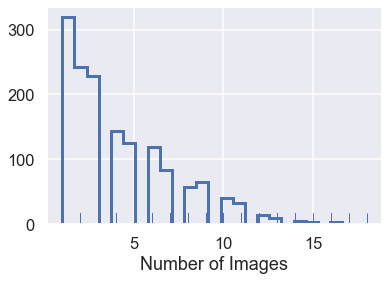

In [16]:
patients = list(df['patient_id'].unique())
num_unique_total = len(patients) # Number of unique patients in entire dataset
print(num_unique_total)

# Not all patients are equal in terms of contributed images!
tmp = df['patient_id'].value_counts().to_numpy()
sns.set()
sns.set_context('talk')
ax = sns.distplot(tmp, 
                  rug=True, 
                  kde=False,
                  norm_hist=False, 
                  hist_kws={"histtype": "step", "linewidth": 3,"alpha": 1,}, 
                  axlabel='Number of Images')
sns.set_style("dark")

In [17]:
df.columns

Index(['id', 'labeled_data', 'label', 'created_by', 'external_id', 'dataset_name', 'is_non-diagnostic_', 'vertical_bone_loss', 'has_erosion/attrition', 'horizontal_bone_loss_', 'no_finding', 'mandibular', 'maxillary', 'calculus', 'primary_decay', 'secondary_decay', 'defective_restoration', 'patient_id', 'patient', 'image_id', 'clinic_id'], dtype='object')

In [18]:
class_names = ['calculus', 'primary_decay', 'secondary_decay', 'defective_restoration']

# How many of each are actually labeled
for cl in class_names:
    # Turn empty lists into nans to let it play well with pandas
    df[cl] = df[cl].apply(lambda x: np.nan if len(x)==0 else x)

df.count()

id                       6328
labeled_data             6328
label                    6328
created_by               6328
external_id              6328
dataset_name             6328
is_non-diagnostic_        502
vertical_bone_loss        411
has_erosion/attrition      69
horizontal_bone_loss_    1667
no_finding                911
mandibular                147
maxillary                 138
calculus                 1032
primary_decay            2284
secondary_decay          1005
defective_restoration    2305
patient_id               6328
patient                     0
image_id                 6328
clinic_id                6328
dtype: int64

In [19]:
pos_weight = torch.Tensor([df[cl].notna().sum() / df.shape[0] for cl in class_names])
pos_weight

tensor([0.1631, 0.3609, 0.1588, 0.3643])

In [20]:
save_dir = '../../data/disease'

#Fraction of data saved for testing and validation, respectively
split = 0.3
continuing = False

def balance_dataset(df, class_names, split=0.3, save_dir='data', continuing=False):
    if continuing:
        # Make sure to use the same dataset if continuing to train on the same model
        return df  
    else: 
        patients = list(df['patient_id'].unique())
        num_unique_total = len(patients) # Number of unique patients in entire dataset

        # Creating data indices for training and validation splits:
        n_val = int( num_unique_total * split )  # number of test/val elements
        n_train = num_unique_total - n_val

        n_val_images = int(len(df) * split)
        n_train_images = len(df) - n_val_images

        # Create phase column as we will be shuffling and splitting the dataframe
        df['phase'] = np.nan

        # Just use the presence of classes within the image to determine balance for now.
        pos_weight = torch.Tensor([df[cl].notna().sum() / df.shape[0] for cl in class_names])
        desired_class_balance = pos_weight.numpy()

        # Keep shuffling until I get a reasonably-sized train-test split
        shuffle_dataset = True
        random_seed= 42

        # The actual number of images in each subset
        true_n_val = 1
        true_n_train = 1

        train_patients = patients[:n_train]
        train_indices = df.loc[df['patient_id'].isin(train_patients)]

        val_patients = patients[n_train:]
        val_indices = df.loc[df['patient_id'].isin(val_patients)]

        # Each subset needs to have relatively balanced classes
        val_fraction = [val_indices[cl].notna().sum() / true_n_val for cl in class_names]
        train_fraction = [train_indices[cl].notna().sum() / true_n_train for cl in class_names]

        # Make sure there are enough images in the unaugmented validation set
        while (true_n_val < n_val_images
        or np.abs(val_fraction-desired_class_balance).mean() > 0.1
        or np.abs(train_fraction-desired_class_balance).mean() > 0.1):
            if shuffle_dataset :
                np.random.seed(random_seed)
                np.random.shuffle(patients)

            train_patients = patients[:n_train]
            train_indices = df[df['patient_id'].isin(train_patients)]

            val_patients = patients[n_train:]
            val_indices = df[df['patient_id'].isin(val_patients)]

            true_n_val = len(val_indices)
            true_n_train = len(train_indices)

            val_fraction = [val_indices[cl].notna().sum() / true_n_val for cl in class_names]
            train_fraction = [train_indices[cl].notna().sum() / true_n_train for cl in class_names]

        print(class_names)
        print('Val fraction:\n', [np.round(x,2) for x in val_fraction])
        print('Train fraction:\n', [np.round(x,2) for x in train_fraction])
        print('Patient split:\n', len(val_patients), len(train_patients))
        print('Image split:\n', true_n_val, true_n_train)

        train_indices.loc[:,'phase'] = 'train'
        val_indices.loc[:,'phase'] = 'val'

        # Recombine the dataframe
        df = pd.concat([train_indices, val_indices])   
        
        return df

In [21]:
df = balance_dataset(df, class_names, split=0.3, save_dir='../../data/disease', continuing=False)
df.head(2)

['calculus', 'primary_decay', 'secondary_decay', 'defective_restoration']
Val fraction:
 [0.17, 0.36, 0.17, 0.38]
Train fraction:
 [0.16, 0.36, 0.15, 0.36]
Patient split:
 448 1048
Image split:
 1951 4377


/home/devin/miniconda3/envs/anatomy/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,id,labeled_data,label,created_by,external_id,dataset_name,is_non-diagnostic_,vertical_bone_loss,has_erosion/attrition,horizontal_bone_loss_,no_finding,mandibular,maxillary,calculus,primary_decay,secondary_decay,defective_restoration,patient_id,patient,image_id,clinic_id,phase
2,cjyg30qd0kbyz0738du3zs3u3,https://storage.googleapis.com/clinic2_rawdata...,{'Primary Decay': [{'how_confident_are_you?': ...,drlaraconnects@gmail.com,5068~28103.jpg/5068/3,disease_data_fp_7_23_2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[[711, 50, 774, 107], [711, 50, 774, 107], [68...","[[688, 399, 717, 449], [688, 399, 717, 449]]","[[218, 449, 241, 480], [218, 449, 241, 480]]",3_5068,NaN,3_5068_28103,3,train
3,cjyg3329lkfiv0701lyrg25k7,https://storage.googleapis.com/clinic2_rawdata...,{'the_image': ['is_non-diagnostic_']},drlaraconnects@gmail.com,2120~29042.jpg/2120/3,disease_data_fp_7_23_2019,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3_2120,NaN,3_2120_29042,3,train


In [125]:
def create_disease_dataset(json_name, dataroot):

    label_types = ['Calculus', 'Primary Decay', 'Secondary Decay', 'Defective Restoration']
    class_names = [name.strip().lower().replace(' ', '_') for name in label_types]


    # import the json data from the json file. We will use this data to generate the label masks
    with open(Path(dataroot, f'{dataset_name}.json')) as f:
        raw_data = json.load(f)

    # Load into a dataframe
    df = pd.DataFrame(raw_data)
    
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

    df['dataset_name'] = json_name

    # we need to clean the json data to create a dataframe where we can get the label by using the External ID
    df = parse_dataframe(df, label_types, label_transform)

    # Clean up labels and extract patient IDs
    df = clean_dataframe(df)

    df = balance_dataset(df, class_names, split=0.3, continuing=False)

    # directory for downloaded images
    download_dir = Path(dataroot, 'imgs')

    # Create directory structure if it does not exist
    download_dir.mkdir(parents=True,
                            exist_ok=True)

#     # get a list of images that have not been downloaded
#     to_download = check_downloaded(df, download_dir)

    # download images and update dataframe
    df = download_imgs(df, download_dir)

    return df, label_types


In [ ]:
df, label_types = create_disease_dataset('disease_data_fp_7_23_2019', '../data/raw')

In [168]:
df.reset_index()

df['all_boxes'] = np.nan
df['all_boxes'] = df['all_boxes'].astype(object)

df['all_labels'] = np.nan
df['all_labels'] = df['all_labels'].astype(object)
    
for i in range(len(df)):
    bboxes = []
    labels = []
    for cl in class_names:
        to_add = df.at[i, cl]
        if type(to_add)==list:
            if type(to_add[0])==int:
                bboxes.append(to_add)
                labels.append(cl)
            elif type(to_add[0])==list:
                
                for j in range(len(to_add)):
                    bboxes.append(to_add[j])
                    labels.append(cl)
                    
    df.at[i, 'all_boxes'] = full
    df.at[i, 'all_labels'] = labels

df.head(2)

,id,labeled_data,label,created_by,external_id,dataset_name,is_non-diagnostic_,vertical_bone_loss,has_erosion/attrition,horizontal_bone_loss_,no_finding,mandibular,maxillary,calculus,primary_decay,secondary_decay,defective_restoration,patient_id,patient,image_id,clinic_id,phase,image_path,full,all_boxes,all_labels
2,cjyg30qd0kbyz0738du3zs3u3,https://storage.googleapis.com/clinic2_rawdata...,{'Primary Decay': [{'how_confident_are_you?': ...,drlaraconnects@gmail.com,5068~28103.jpg/5068/3,disease_data_fp_7_23_2019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[[711, 50, 774, 107], [711, 50, 774, 107], [68...","[[688, 399, 717, 449], [688, 399, 717, 449]]","[[218, 449, 241, 480], [218, 449, 241, 480]]",3_5068,NaN,3_5068_28103,3,train,../data/train/imgs/disease_data_fp_7_23_2019_3...,"[[711, 50, 774, 107], [711, 50, 774, 107], [68...","[[539, 399, 586, 437], [539, 399, 586, 437], [...","[primary_decay, primary_decay, primary_decay, ..."
3,cjyg3329lkfiv0701lyrg25k7,https://storage.googleapis.com/clinic2_rawdata...,{'the_image': ['is_non-diagnostic_']},drlaraconnects@gmail.com,2120~29042.jpg/2120/3,disease_data_fp_7_23_2019,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3_2120,NaN,3_2120_29042,3,train,../data/train/imgs/disease_data_fp_7_23_2019_3...,[],"[[539, 399, 586, 437], [539, 399, 586, 437], [...",[]
